# Analiza zbioru Titanic (seaborn) – Drzewo decyzyjne i KNN

**Cel:** przewidzieć, którzy pasażerowie przeżyli katastrofę Titanica.

- Zbiór danych: `titanic` z biblioteki **seaborn**
- Zmienna docelowa: `survived` (0 = nie przeżył, 1 = przeżył)
- Cechy:
  - `pclass` – klasa podróży (1, 2, 3)
  - `sex` – płeć
  - `age` – wiek
  - `sibsp` – liczba rodzeństwa/małżonków na pokładzie
  - `parch` – liczba rodziców/dzieci na pokładzie
  - `fare` – cena biletu
  - `embarked` – port zaokrętowania (C, Q, S)

W notatniku wykonujemy:
1. Przygotowanie danych (imputacja braków + kodowanie kategorii + podział train/test)  
2. Drzewo decyzyjne: test `max_depth = 2, 3, 5, 7, 10, None`, metryki (accuracy, precision, recall, F1), wybór najlepszego i wizualizacja  
3. KNN: normalizacja cech (StandardScaler), test `k = 1, 3, 5, 7, 9, 11, 15`, wykres accuracy(k)  
4. Porównanie i wnioski


In [11]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import matplotlib.pyplot as plt

## 1) Wczytanie danych i podstawowy przegląd

In [12]:
df = sns.load_dataset("titanic")
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [13]:
# Wybieramy tylko wymagane kolumny
features = ["pclass", "sex", "age", "sibsp", "parch", "fare", "embarked"]
target = "survived"

data = df[features + [target]].copy()

# Braki danych
data.isna().sum()

,0
pclass,0
sex,0
age,177
sibsp,0
parch,0
fare,0
embarked,2
survived,0


### Podział na X / y oraz train / test

Stosujemy **stratyfikację**, aby zachować podobny rozkład klas (0/1) w zbiorze uczącym i testowym.


In [14]:
X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape

((712, 7), (179, 7))

## 2) Preprocessing (przygotowanie danych)

- Cechy liczbowe: imputacja medianą  
- Cechy kategoryczne: imputacja najczęstszą wartością + OneHotEncoder  
- Dla KNN dodatkowo: **StandardScaler** na cechach liczbowych (bo KNN używa odległości)


In [15]:
numeric_features = ["pclass", "age", "sibsp", "parch", "fare"]
categorical_features = ["sex", "embarked"]

numeric_preprocess_no_scaling = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

numeric_preprocess_with_scaling = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess_for_tree = ColumnTransformer(
    transformers=[
        ("num", numeric_preprocess_no_scaling, numeric_features),
        ("cat", categorical_preprocess, categorical_features),
    ],
    remainder="drop"
)

preprocess_for_knn = ColumnTransformer(
    transformers=[
        ("num", numeric_preprocess_with_scaling, numeric_features),
        ("cat", categorical_preprocess, categorical_features),
    ],
    remainder="drop"
)

### Funkcje pomocnicze (metryki + nazwy cech po OneHot)

In [16]:
def compute_metrics(y_true, y_pred):
    """Zwraca podstawowe metryki dla klasy 1 (survived=1)."""
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
    }

def get_feature_names_from_column_transformer(ct: ColumnTransformer):
    """Zwraca listę nazw cech po transformacjach (num + onehot)."""
    feature_names = []

    # num
    _, _, num_cols = ct.transformers_[0]
    feature_names.extend(list(num_cols))

    # cat
    _, cat_trans, cat_cols = ct.transformers_[1]
    ohe = cat_trans.named_steps["onehot"]
    ohe_names = list(ohe.get_feature_names_out(cat_cols))
    feature_names.extend(ohe_names)

    return feature_names

## 3) Drzewo decyzyjne – eksperyment z `max_depth`

Testujemy: `max_depth = 2, 3, 5, 7, 10, None`

Dla każdej wartości liczymy:
- accuracy
- precision
- recall
- F1

Jako główne kryterium wyboru najlepszego modelu przyjmujemy **F1** (kompromis precision/recall).


In [17]:
depths = [2, 3, 5, 7, 10, None]

tree_results = []
tree_models = {}

for d in depths:
    model = Pipeline(steps=[
        ("preprocess", preprocess_for_tree),
        ("clf", DecisionTreeClassifier(random_state=42, max_depth=d))
    ])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    metrics = compute_metrics(y_test, y_pred)
    row = {"max_depth": d, **metrics}
    tree_results.append(row)
    tree_models[d] = model

tree_results_df = pd.DataFrame(tree_results).sort_values(by="f1", ascending=False)
tree_results_df

,max_depth,accuracy,precision,recall,f1
5,NaN,0.826816,0.806452,0.724638,0.763359
4,10.0,0.804469,0.774194,0.695652,0.732824
3,7.0,0.815642,0.846154,0.637681,0.727273
1,3.0,0.793296,0.863636,0.550725,0.672566
2,5.0,0.765363,0.754717,0.579710,0.655738
0,2.0,0.759777,0.861111,0.449275,0.590476


In [18]:
best_depth = tree_results_df.iloc[0]["max_depth"]
best_depth

np.float64(nan)

### Który `max_depth` jest najlepszy i dlaczego?

- **Za małe `max_depth`** → drzewo jest zbyt proste, nie uchwyci zależności (underfitting / duży bias) → gorsze metryki.
- **Za duże `max_depth` lub `None`** → drzewo może dopasować się do szumu w danych (overfitting / duża wariancja) → metryki na teście mogą spadać.

Najlepsze `max_depth` wybieramy jako to z najwyższą **F1** w tabeli.


### Wizualizacja najlepszego drzewa

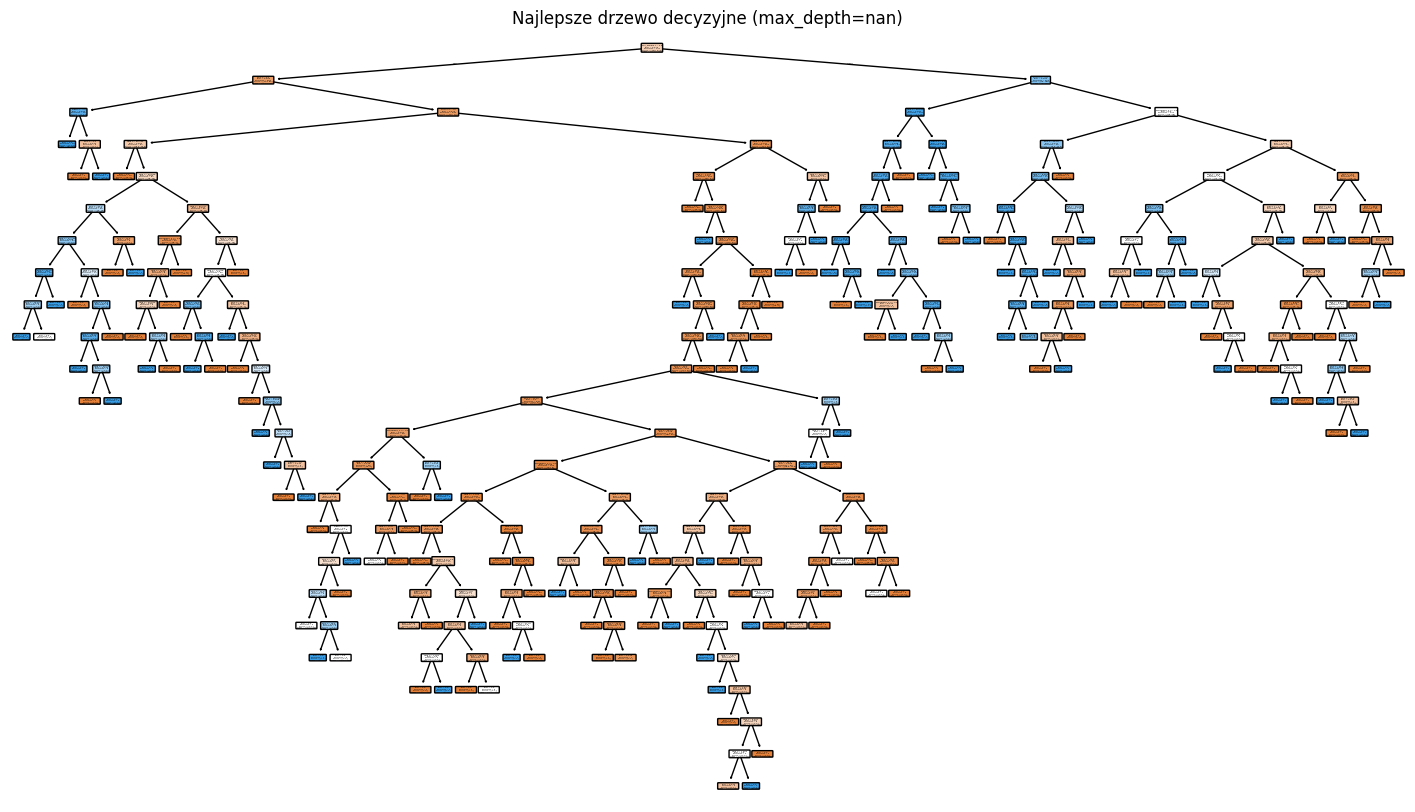

In [19]:
best_depth_key = best_depth
if pd.isna(best_depth):
    best_depth_key = None

best_tree_model = tree_models[best_depth_key]
best_tree_clf = best_tree_model.named_steps["clf"]
best_tree_pre = best_tree_model.named_steps["preprocess"]

feature_names = get_feature_names_from_column_transformer(best_tree_pre)

plt.figure(figsize=(18, 10))
plot_tree(
    best_tree_clf,
    feature_names=feature_names,
    class_names=["nie przeżył", "przeżył"],
    filled=True,
    rounded=True,
    impurity=True
)
plt.title(f"Najlepsze drzewo decyzyjne (max_depth={best_depth})")
plt.show()

## 4) KNN – eksperyment z hiperparametrem `k`

KNN korzysta z odległości, więc **normalizacja** jest kluczowa (tu: `StandardScaler` dla cech liczbowych).

Testujemy: `k = 1, 3, 5, 7, 9, 11, 15`  
Dla każdego k liczymy metryki i rysujemy wykres **accuracy(k)**.


In [20]:
ks = [1, 3, 5, 7, 9, 11, 15]

knn_results = []
knn_models = {}

for k in ks:
    model = Pipeline(steps=[
        ("preprocess", preprocess_for_knn),
        ("clf", KNeighborsClassifier(n_neighbors=k))
    ])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    metrics = compute_metrics(y_test, y_pred)
    row = {"k": k, **metrics}
    knn_results.append(row)
    knn_models[k] = model

knn_results_df = pd.DataFrame(knn_results).sort_values(by="f1", ascending=False)
knn_results_df

,k,accuracy,precision,recall,f1
1,3,0.815642,0.772727,0.739130,0.755556
2,5,0.815642,0.800000,0.695652,0.744186
6,15,0.804469,0.783333,0.681159,0.728682
3,7,0.798883,0.779661,0.666667,0.718750
4,9,0.793296,0.766667,0.666667,0.713178
5,11,0.793296,0.775862,0.652174,0.708661
0,1,0.720670,0.626667,0.681159,0.652778


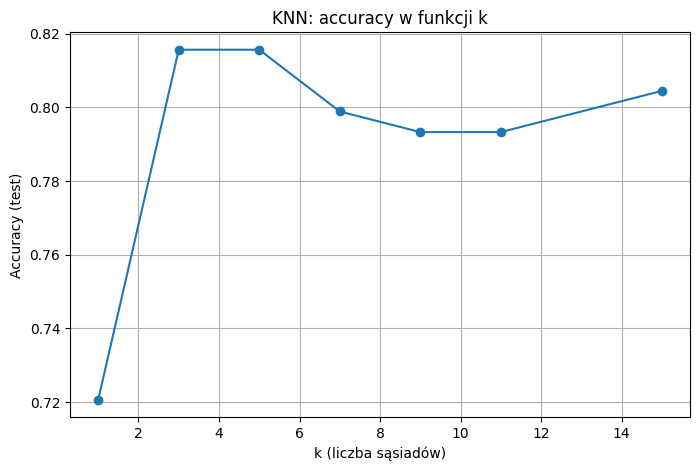

In [21]:
# Wykres accuracy w funkcji k
sorted_df = knn_results_df.sort_values("k")

plt.figure(figsize=(8, 5))
plt.plot(sorted_df["k"], sorted_df["accuracy"], marker="o")
plt.xlabel("k (liczba sąsiadów)")
plt.ylabel("Accuracy (test)")
plt.title("KNN: accuracy w funkcji k")
plt.grid(True)
plt.show()

In [22]:
best_k = knn_results_df.iloc[0]["k"]
best_k

np.float64(3.0)

### Które `k` jest optymalne i dlaczego?

- **Za małe k (np. 1)** → model bardzo „nerwowy”, wrażliwy na szum i pojedyncze obserwacje (overfitting, duża wariancja).
- **Za duże k** → model zbyt mocno uśrednia (underfitting, duży bias).

Optymlane `k` wybieramy jako to z najwyższą **F1** w tabeli.


## 5) Porównanie i wnioski

Porównujemy najlepsze konfiguracje obu modeli (wg F1):
- Drzewo: `max_depth = best_depth`
- KNN: `k = best_k`


In [23]:
best_tree_row = tree_results_df.iloc[0].to_dict()
best_knn_row = knn_results_df.iloc[0].to_dict()

summary_df = pd.DataFrame([
    {"model": "DecisionTree", "najlepszy_parametr": f"max_depth={best_depth}",
     "accuracy": best_tree_row["accuracy"], "precision": best_tree_row["precision"],
     "recall": best_tree_row["recall"], "f1": best_tree_row["f1"]},
    {"model": "KNN", "najlepszy_parametr": f"k={best_k}",
     "accuracy": best_knn_row["accuracy"], "precision": best_knn_row["precision"],
     "recall": best_knn_row["recall"], "f1": best_knn_row["f1"]},
])

summary_df

,model,najlepszy_parametr,accuracy,precision,recall,f1
0,DecisionTree,max_depth=nan,0.826816,0.806452,0.724638,0.763359
1,KNN,k=3.0,0.815642,0.772727,0.739130,0.755556


### Odpowiedzi na pytania „Do przemyślenia”

**Który model działa lepiej?**  
Model z wyższą F1 na zbiorze testowym uznajemy za lepszy w tym zadaniu.

**Co się dzieje przy zbyt małym/dużym `max_depth`?**  
- Zbyt małe: underfitting → gorsze wyniki, bo model jest za prosty.  
- Zbyt duże: overfitting → model uczy się „szumu” i gorzej generalizuje.

**Co się dzieje przy zbyt małym/dużym `k`?**  
- Zbyt małe: overfitting (duża wariancja) → wrażliwość na szum.  
- Zbyt duże: underfitting (duży bias) → zbyt duże uśrednianie decyzji.

